In [145]:
import numpy as np
import numpy.matlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler 

In [146]:
game_data = pd.read_csv('games.csv')

In [147]:
print(game_data.columns)
print('size : ',game_data.shape )
game_data.head(1)

Index(['id', 'rated', 'created_at', 'last_move_at', 'turns', 'victory_status',
       'winner', 'increment_code', 'white_id', 'white_rating', 'black_id',
       'black_rating', 'moves', 'opening_eco', 'opening_name', 'opening_ply'],
      dtype='object')
size :  (20058, 16)


,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5


From this data well need to find correlation between points 

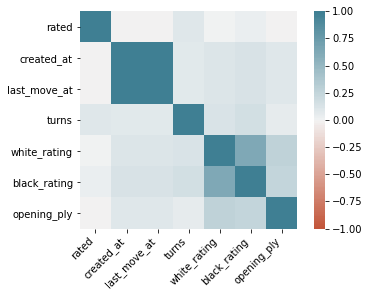

In [148]:
fig, a1 = plt.subplots()
corr = game_data.corr()
a1 = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
a1.set_xticklabels(
    a1.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

    As expected most of these points wont be useful in a prediction on who has a winning advantage but we can seethat white_rating, black_Rating have a corrilation. We will need to create more data points to undestand what type of  relationship is here. 

A quick basic test we can see the relationship is related and that this would transfer to the real world. Where if someone is more skilled there rank is higher, But we can do better since we are given opening data and that openings are 2-4 moves in. We can consider this the begging if the game. With the goal to Guess the winner at the beginning of the game we can use this data.  

In [149]:
### Knowing that white has an advantage lets see if this is show. 
le = preprocessing.LabelEncoder()
winners = game_data[['winner']]
winners = winners.apply(le.fit_transform)

whiteWins = 0
blackWins = 0
third = 0

white_rating = np.array(game_data['white_rating'])
black_rating = np.array(game_data['black_rating'])
win = np.array(winners)

for index in range(len(winners)):
    if win[index][0] == 0 and black_rating[index] > white_rating[index]:
        blackWins+=1
    elif win[index][0] == 2 and black_rating[index] < white_rating[index]:
        whiteWins+=1
    else:
        third+=1
print(whiteWins/len(winners),blackWins/len(winners),third/len(winners))
  

0.3255060325057334 0.2903081064911756 0.38418586100309104


This shows that betting on the higher rated player is 61% likely to win and if white is higher rated there even more likely to win.

In [150]:
## Label Encoder #### white_id # black_id # opening_name # victory_status # winner # rated # opening_ply
le = preprocessing.LabelEncoder()
winners = game_data[['winner']]
winners = winners.apply(le.fit_transform)

incoded_values = game_data[['white_id','black_id','rated','opening_name','opening_ply']]
victory_status = game_data[['victory_status']]

incoded_values = incoded_values.apply(le.fit_transform)

victory_status = victory_status.apply(le.fit_transform)

#whosHigherRated #
def whosHigherRated(df):
    l = []
    numWhite = 0
    numBlack = 0
    white_rating = np.array(df['white_rating'])
    black_rating = np.array(df['black_rating'])
    for index in range(len(white_rating)):
        if white_rating[index] > black_rating[index]:
            l.append(1)
            numWhite+=1
        else:
            numBlack+=1
            l.append(0)
    print("White : ",numWhite)
    print("Black : ",numBlack)
    return 1

def classification(df):
    df['whosRatedHigher'] = whosHigherRated(game_data)
classification(incoded_values)

incoded_values['white_rating'] = game_data['white_rating']
incoded_values['black_rating'] = game_data['black_rating']

print(incoded_values.head(2))
# black 0 white 2 draw 1
print(winners.head(2))

White :  10184
Black :  9874
   white_id  black_id  rated  opening_name  opening_ply  whosRatedHigher  \
0      1287        11      0          1387            4                1   
1        16      7748      1           750            3                1   

   white_rating  black_rating  
0          1500          1191  
1          1322          1261  
   winner
0       2
1       0


Using This incoded data we can alberate look to see the relative stangth of a opening.

The next cell takes all openings victory_status and whos the winner and finds the probablity each outcome happened. 
Since this data is uses in the the fitting model this would be bad since its aggregate, but with the fact that we created persetages theses would be the same with the training and testing model given enough data. 

In [151]:
# draw = 0, outoftime = 2, mate = 1 resign = 3, white won = 4, black won = 5, draw = 6
def checkClassificationOfOpenings(df,v_status,winners): 
    dict = {}
    openings = df['opening_name']
    v_status = v_status['victory_status']
    for index in range(len(openings)):
#         print(game_data['victory_status'][index],v_status[index])
#         print(game_data['winner'][index], winners['winner'][index])
        if openings[index] not in dict.keys():
            dict[openings[index]] = [0,0,0,0,0,0,0]
            dict[openings[index]][v_status[index]]+=1
        else:
            dict[openings[index]][v_status[index]]+=1
        
        # black 0 white 2 draw 1
        if winners['winner'][index] == 0:
            dict[openings[index]][5]+=1
        elif winners['winner'][index] == 2: 
            dict[openings[index]][4]+=1
        else:
            dict[openings[index]][6]+=1 
    return dict 

dict = checkClassificationOfOpenings(incoded_values,victory_status,winners)

def checkPersentages(df,dict):
    openings = df['opening_name']
    for index in range(len(openings)):
        l = dict[openings[index]] 
        Lsum = l[0]+l[1]+l[2]+l[3]
        rounded = [round(num, 2) for num in [l[0]/Lsum,l[1]/Lsum,l[2]/Lsum,l[3]/Lsum, l[4]/Lsum,l[5]/Lsum,l[6]/Lsum]]
        dict[openings[index]] = rounded
#         print(rounded)
           
checkPersentages(incoded_values,dict)

# draw = 0, outoftime = 2, mate = 1 resign = 3, white won = 4, black won = 5, draw = 6
def createColumns(df, openings, dict):
    openingDrawPercentage = []
    openingOutoftimePercentage  = []
    openingMatePercentage  = []
    openingResignPercentage  = []
    percentageWhiteWon = []
    percentageBlakeWon = []
    percentageGamedraw = []
    for index in range(len(openings)):
        l = dict[openings[index]]
        openingDrawPercentage.append(l[0])
        openingOutoftimePercentage.append(l[1])
        openingMatePercentage.append(l[2])
        openingResignPercentage.append(l[3])
        percentageWhiteWon.append(l[4])
        percentageBlakeWon.append(l[5])
        percentageGamedraw.append(l[6])
    df['openingDrawPercentage'] = openingDrawPercentage
    df['openingOutoftimePercentage'] = openingOutoftimePercentage
    df['openingMatePercentage'] = openingMatePercentage
    df['openingResignPercentage'] = openingResignPercentage
    df['percentageWhiteWon'] = percentageWhiteWon
    df['percentageBlakeWon'] = percentageBlakeWon
    df['percentageGamedraw'] = percentageGamedraw
createColumns(incoded_values,incoded_values['opening_name'] , dict)
incoded_values.head(2)

,white_id,black_id,rated,opening_name,opening_ply,whosRatedHigher,white_rating,black_rating,openingDrawPercentage,openingOutoftimePercentage,openingMatePercentage,openingResignPercentage,percentageWhiteWon,percentageBlakeWon,percentageGamedraw
0,1287,11,0,1387,4,1,1500,1191,0.0,0.21,0.16,0.63,0.37,0.63,0.0
1,16,7748,1,750,3,1,1322,1261,0.0,0.20,0.00,0.80,0.60,0.40,0.0


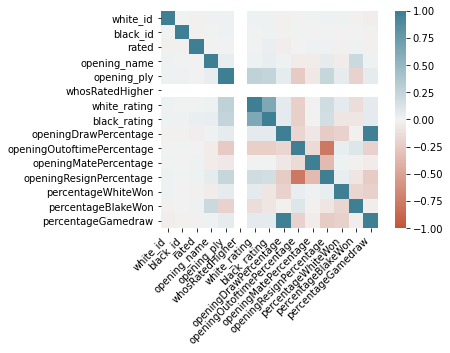

In [152]:
fig, a1 = plt.subplots()
corr = incoded_values.corr()
a1 = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
a1.set_xticklabels(
    a1.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Much better 

# Looking into popular starting moves

## Which moves are the most popular?

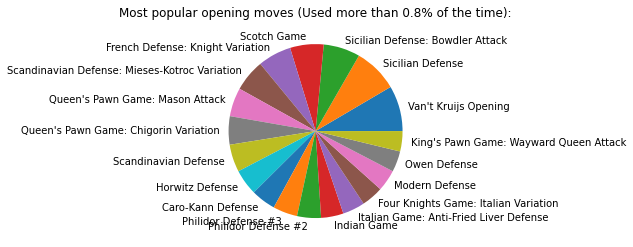

In [153]:
#grab lebels a number of occurences for each label
opening_moves_set = game_data['opening_name'].value_counts()
#remove least popular moves
opening_moves_set = opening_moves_set[opening_moves_set.gt(160)]
#show pie chart
plt.pie(opening_moves_set, labels = opening_moves_set.keys())
plt.title('Most popular opening moves (Used more than 0.8% of the time):')
plt.show()

## Comparing the most popular moves based on the percentage of games they win

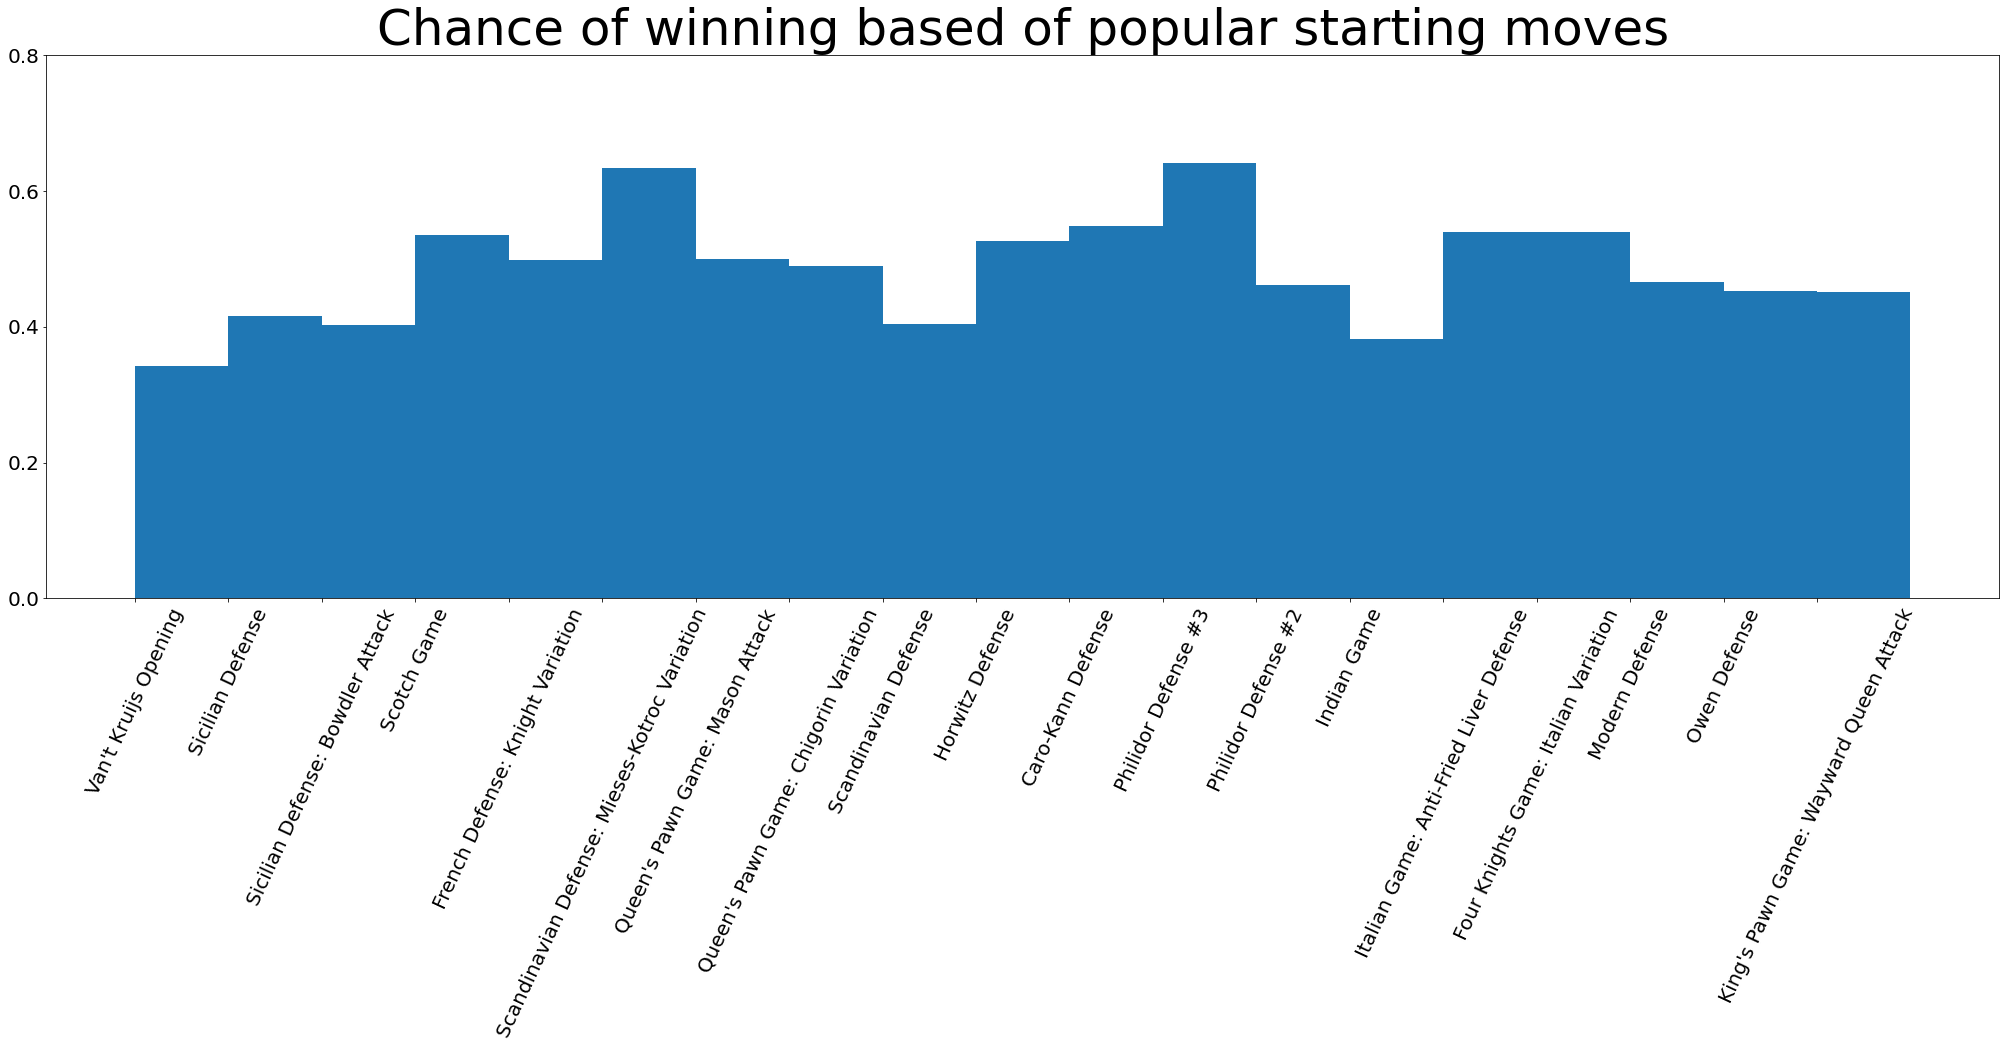

In [154]:
#most popular opening moves vs wins with those moves
temp = game_data[game_data['winner'] == 'white'] #show only winning games for the openning move
temp = temp[temp['opening_name'].isin(opening_moves_set.keys())] #remove games with non-popular starting moves
winning_opening_moves_set = temp['opening_name'].value_counts()
percents = pd.Series(float)
index = opening_moves_set.keys()
flag = False
for key in index:
    #print(percents.index.max())
    val = float(winning_opening_moves_set.get(key)) / float(opening_moves_set.get(key))
    if (flag):
        percents.loc[percents.index.max()+1] = val
    else:
        flag = True
        percents.loc[percents.index.max()] = val
percents.index = index
plt.figure(figsize=(35,10))
plt.bar(range(1, 20), percents, align='edge', width=1)
plt.yticks(np.linspace(0,1,5,endpoint=False), fontsize=20)
plt.xticks(range(1, 20), percents.keys(), rotation=65, fontsize=20)
plt.title('Chance of winning based of popular starting moves', fontsize=50)
plt.show()

## Adjusting the comparison to remove bias towards less popular moves

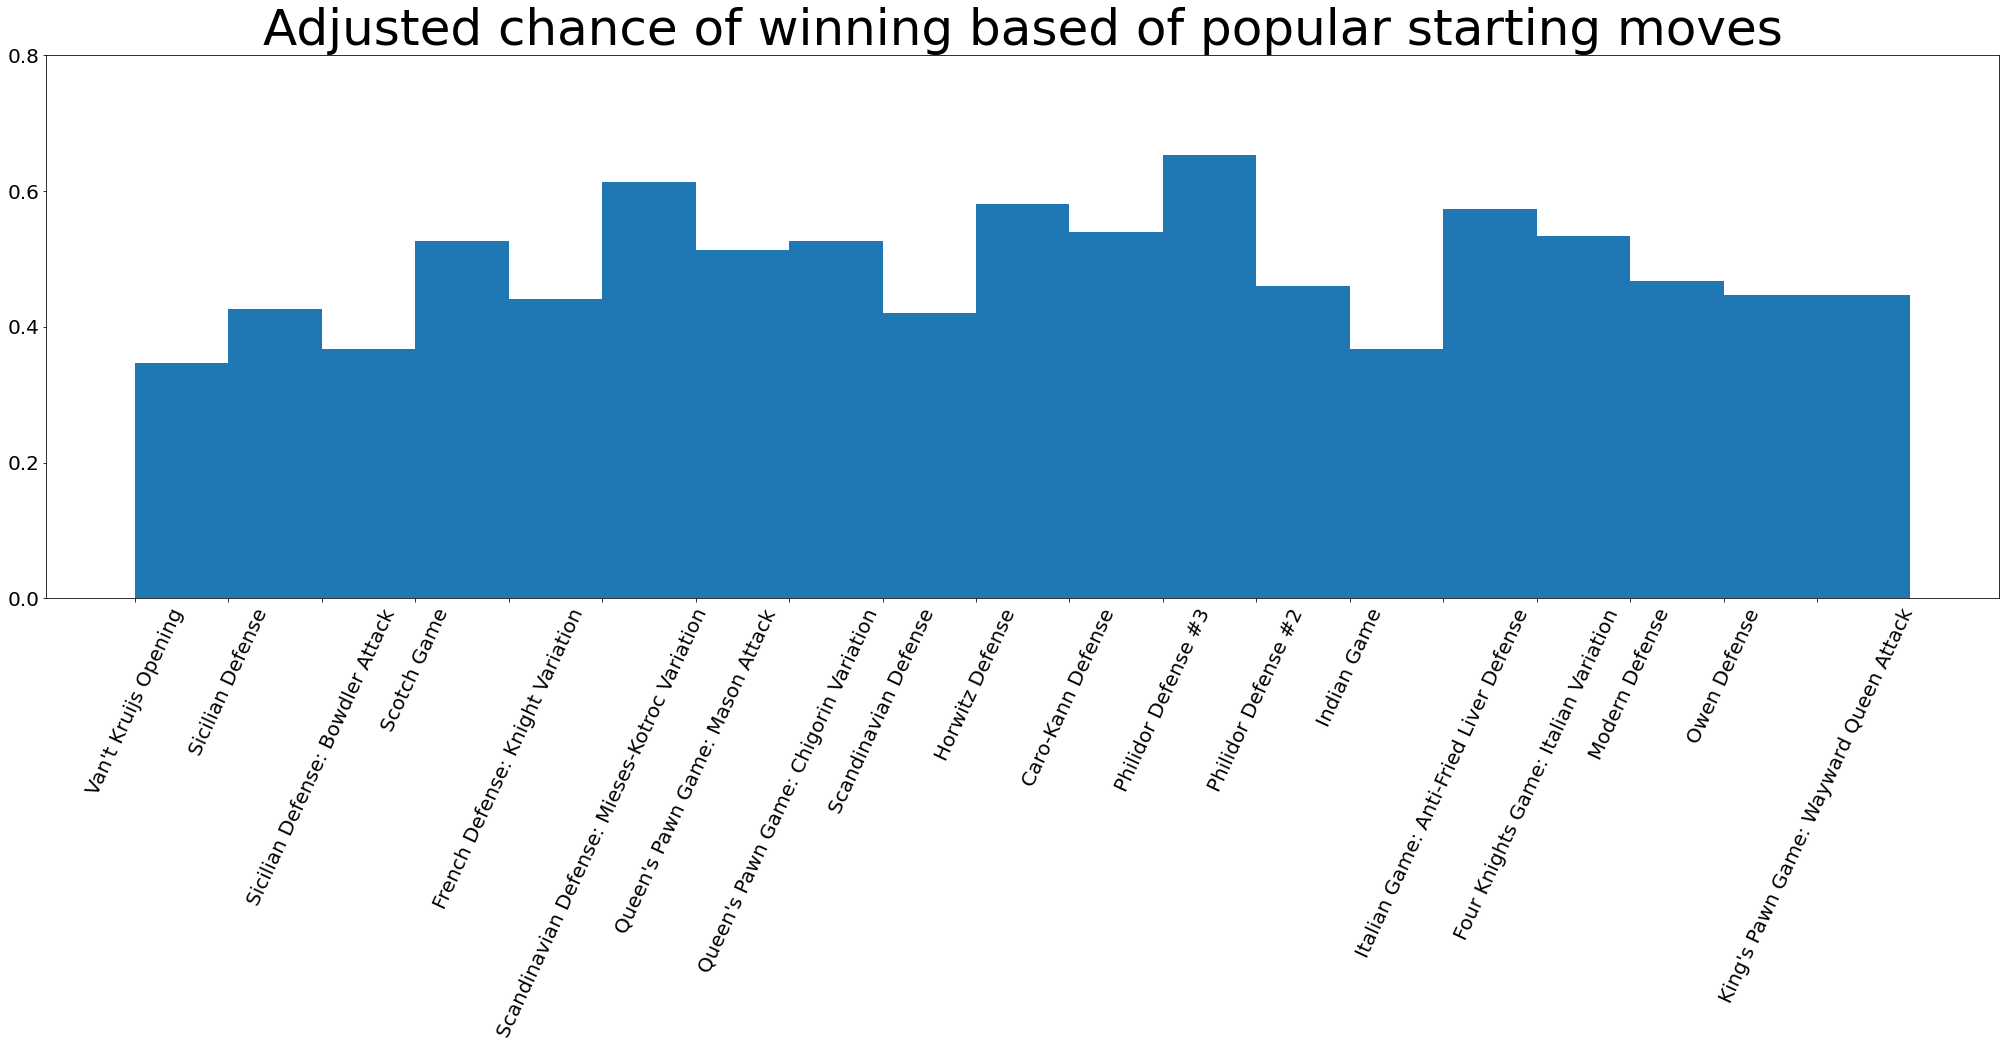

In [155]:
#sample 150 random games from each opening move
index = opening_moves_set.keys()
temp = game_data#[game_data['winner'] == 'white'] #show only winning games for the openning move
temp = temp[temp['opening_name'].isin(index)] #remove games with non-popular starting moves
Adjusted_data = pd.DataFrame()
percents = pd.Series(float)
flag = False
for key in index:
    temp2 = temp[temp['opening_name'] == key]
    temp2 = temp2.sample(n=150,axis=0)
    temp2 = temp2[temp2['winner'] == 'white']
    winning_opening_moves_set = temp2['opening_name'].value_counts()
    val = float(winning_opening_moves_set.get(key)) / 150.0
    if (flag):
        percents.loc[percents.index.max()+1] = val
    else:
        flag = True
        percents.loc[percents.index.max()] = val
percents.index = index
plt.figure(figsize=(35,10))
plt.bar(range(1, 20), percents, align='edge', width=1)
plt.yticks(np.linspace(0,1,5,endpoint=False), fontsize=20)
plt.xticks(range(1, 20), percents.keys(), rotation=65, fontsize=20)
plt.title('Adjusted chance of winning based of popular starting moves', fontsize=50)
plt.show()

In [156]:
x_train, x_test, y_train, y_test = train_test_split(incoded_values, winners, test_size=0.30, random_state = 0)  

wcart2 = MLPClassifier()
wcart2.fit(x_train, y_train)
y_pred = wcart2.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("confusion_matrix")
print(confusion_matrix(y_test, y_pred))

/usr/local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy: 0.4567962778331672
confusion_matrix
[[ 108  575 2074]
 [   4   71  193]
 [  27  396 2570]]


In [157]:

##minMax scailing testing minMax
def minMaxMethod(data):
    from sklearn.preprocessing import MinMaxScaler
    # fit scaler on training data
    norm = MinMaxScaler().fit(data)
    # transform training data
    x = norm.transform(data)
    return(x)

x_train = minMaxMethod(x_train)
x_test = minMaxMethod(x_test)
# minMaxMethod()

# minMaxMethod()
x_train = pd.DataFrame(x_train, columns =(list(incoded_values.columns))) 
x_test = pd.DataFrame(x_test, columns =(list(incoded_values.columns))) 
y_train = pd.DataFrame(list(y_train['winner']), columns =['winner'])
y_test = pd.DataFrame(list(y_test['winner']), columns =['winner'])
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)


(14040, 15) (14040, 1) (6018, 15) (6018, 1)


Now lets test this data  

In [158]:

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
# initializes and runs the DecisionTreeClassifier
wcart1 = DecisionTreeClassifier()
wcart1.fit(x_train, y_train)

y_pred = wcart1.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("confusion_matrix")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.5722831505483549
confusion_matrix
[[1644  127  986]
 [ 109   48  111]
 [1109  132 1752]]


In [159]:
# initializes and runs the MLPClassifier
from sklearn.neural_network import MLPClassifier
wcart2 = MLPClassifier()
wcart2.fit(x_train, y_train)
y_pred = wcart2.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("confusion_matrix")
print(confusion_matrix(y_test, y_pred))

/usr/local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy: 0.6566965769358591
confusion_matrix
[[1982   11  764]
 [ 137   30  101]
 [1040   13 1940]]


/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [113]:
# initializes and runs the RandomForestClassifier
wcart3 = RandomForestClassifier()
wcart3.fit(x_train, y_train)
y_pred = wcart3.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("confusion_matrix")
print(confusion_matrix(y_test, y_pred))

<ipython-input-113-6767449cddeb>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  wcart3.fit(x_train, y_train)


Accuracy: 0.6482220006646726
confusion_matrix
[[1842   18  897]
 [ 118   32  118]
 [ 944   22 2027]]


In [114]:
# initializes and runs the AdaBoostClassifier
wcart4 = AdaBoostClassifier()
wcart4.fit(x_train, y_train)
y_pred = wcart4.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("confusion_matrix")
print(confusion_matrix(y_test, y_pred))

/usr/local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy: 0.6452309737454304
confusion_matrix
[[1822    9  926]
 [ 126   23  119]
 [ 947    8 2038]]


In [115]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=0)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print("Accuracy:",clf.score(x_test, y_test))
print("confusion_matrix")
print(confusion_matrix(y_test, y_pred))

/usr/local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy: 0.6560319042871385
confusion_matrix
[[1868   10  879]
 [ 124   28  116]
 [ 927   14 2052]]


In [116]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
clf = HistGradientBoostingClassifier(random_state=0)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print("Accuracy:",clf.score(x_test, y_test))

/usr/local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy: 0.6616816218012629


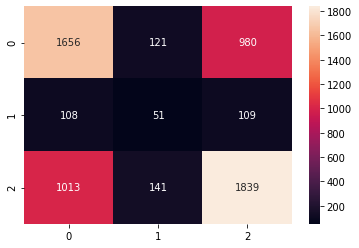

In [34]:
import numpy as np; np.random.seed(0)
import seaborn as sns;
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")

With 66.7% and 64.6% GradientBoosting and AdaBoostClassifier preformed the best andwe increated from 56% to 66% which is the best we could do with the given data. Since this is a game and we are trying to predict a game by the 4th move this quite high considering a piece has been taken yet and such on the board there is no clear differences between them.  

In [140]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

clf = make_pipeline(StandardScaler(),SGDClassifier(max_iter=1000, tol=1e-3))
clf.fit(x_train, y_train)
# Pipeline(steps=[('standardscaler', StandardScaler()),
#                 ('sgdclassifier', SGDClassifier())])

y_pred = clf.predict(x_test)
print("Accuracy:",clf.score(x_test, y_test))

Accuracy: 0.6229644400132934


/usr/local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [ ]:
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()  # for plot styling
x= game_data[['white_rating','black_rating']]
kmeans = KMeans(n_clusters=4)
kmeans.fit(x)
y_kmeans = kmeans.predict(x)
x=np.array(x)
plt.scatter(x[:, 0], x[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], cmap='viridis', s=200, alpha=0.5);